A heat exchanger example
========================
within carbatpy

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import carbatpy as cb

Select two fluid (mixtures) and further conditions. H_DOT is the wanted heatflow rate ($\dot Q = $1 kW) here.

In [15]:
FLUID = "Propane * Pentane"  # working fluid
FLS = "Methanol"  # "Water"  # secondary fluid
comp = [.50, 0.5]
flm = cb.fprop.FluidModel(FLUID)
myFluid = cb.fprop.Fluid(flm, comp)

secFlm = cb.fprop.FluidModel(FLS)
secFluid = cb.fprop.Fluid(secFlm, [1.])
D_TEMP_MIN = 5.0

# Condenser, working fluid fixes all, secondary output enthalpy can be varied:
SEC_TEMP_IN = 300.0  # K
SEC_TEMP_OUT_MAX = 370.0
SEC_PRES_IN = 5e5  # Pa
H_DOT = 1e3  # W

Now set the wanted states, determine the enthalpies (alwas the value state[2] below), needed as input

In [16]:
state_sec_out = secFluid.set_state([SEC_TEMP_OUT_MAX, SEC_PRES_IN], "TP")

state_sec_in = secFluid.set_state(
    [SEC_TEMP_IN, SEC_PRES_IN], "TP")  # this is the entering state

# working fluid

TEMP_SAT_VAP = SEC_TEMP_OUT_MAX + D_TEMP_MIN
state_in = myFluid.set_state(
    [TEMP_SAT_VAP, 1.], "TQ")  # find minimum pressure

WF_TEMP_IN = TEMP_SAT_VAP + D_TEMP_MIN
WF_TEMP_OUT = SEC_TEMP_IN + D_TEMP_MIN
state_out = myFluid.set_state([WF_TEMP_OUT, state_in[1]], "TP")

state_in = myFluid.set_state([myFluid.properties.pressure,
                              WF_TEMP_IN],
                             "PT")

Now we create an instance of the heat exchanger here: hex0. The input are the two Fluid-instances with the correct input states. The enthalpies of the wanted output states (one will be varied later to meet the minimum approach temperature). The pressures will be deduced from the actual values.

In [17]:
hex0 = cb.hex_th.StaticHeatExchanger([myFluid, secFluid], H_DOT, state_out[2],
                           state_sec_out[2],
                           d_temp_separation_min=D_TEMP_MIN)

It is called find_pinch, but it actually just varies the fluid mass flow rate ratio, until the minimum approach temperature(d_temp_separation_min) is reached, if it is possible for the given inlet, wanted outlet values. If not a warning is given.

Min T-distance 4.999, Mean T-distance 13.816
Min T-distance 4.9990002898326225, Mean T-distance 13.816388378792048
cond 4.999999996768054 7.880529723560983 4.9990002898326225 22.9172499170362


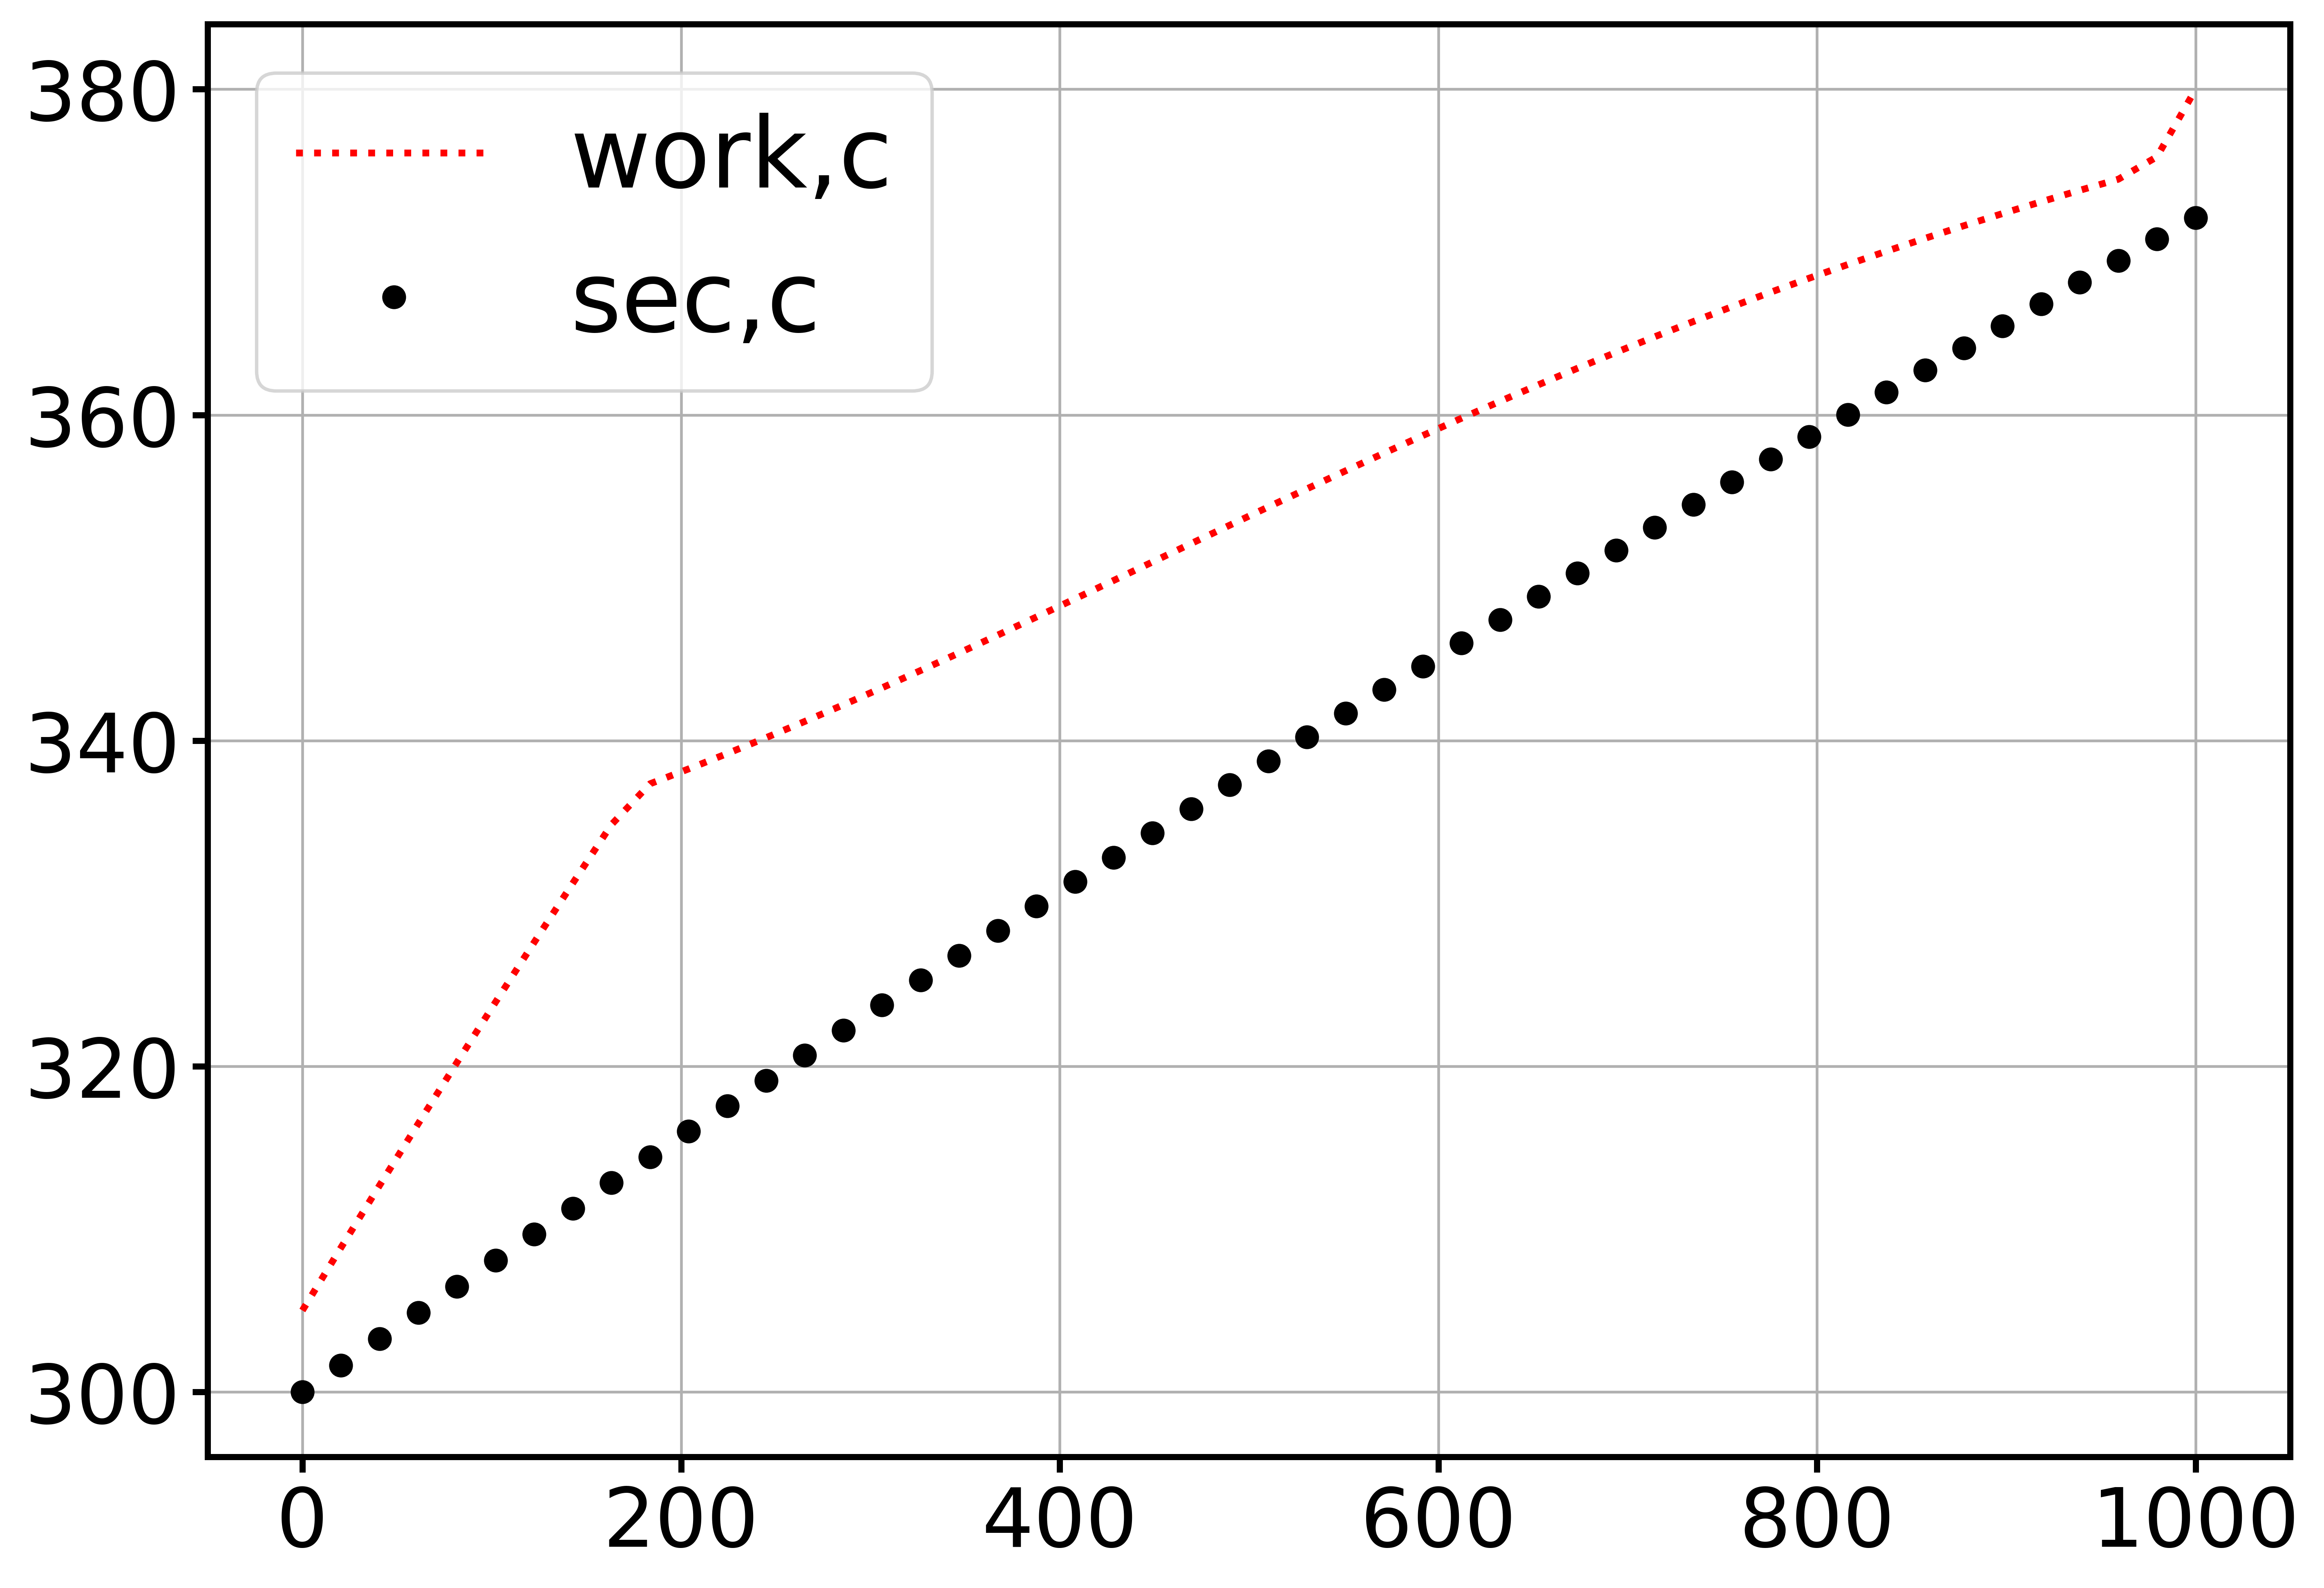

In [18]:
hex0.find_pinch()
if hex0.warning > 0:
    print(hex0.warning_message)

# now plotting can directly be done in pinch_calc 2024-05-24
fig_act, ax_act = plt.subplots(1)
PLOT_INFO = {"fig": fig_act, "ax": ax_act, "what": [2, 0], "col": ["r:", "ko"],
             "label": ["work,c", "sec,c"], "x-shift": [0, 0]}
hex0.plot_info=PLOT_INFO
hex0.pinch_calc(verbose=True)
ax_act.legend()

In [19]:
print(hex0.warning, hex0.warning_message)

0 All o.k.


You can plot a second heat exchanger into the same plot by passing the figure information. But first we need a new instance of an heat exchanger, now an evaporator called hex1:

In [20]:
#  Evaporator: ----------------------------

SEC_TEMP_IN = 300.0 # K
SEC_TEMP_OUT = 285
SEC_PRES_IN = 15e5
H_DOT = 1e3  # heat flow rate
extra = 2  # some additional temperature difference between both fluids at the entrance of the working fluid
# D_TEMP_SUPER = 5.
D_TEMP_MIN = 6.0  # Minimum approach temperature, allowed

state_sec_out = secFluid.set_state([SEC_TEMP_OUT, SEC_PRES_IN], "TP")
state_out = myFluid.set_state([SEC_TEMP_IN-D_TEMP_MIN - extra, 1.0], "TQ")

# the inlet states must be the last set_state before the hex is constructed, because it is further used by the heat exchanger:
state_sec_in = secFluid.set_state([SEC_TEMP_IN, SEC_PRES_IN], "TP")
state_in = myFluid.set_state(
    [SEC_TEMP_OUT-D_TEMP_MIN - extra, state_out[1]], "TP")

print("state in (T,p,h,v,s,q,u):", state_in)

state in (T,p,h,v,s,q,u): [2.77000000e+02 1.04510486e+05 2.37193722e+05 2.21710771e-01
 1.11102909e+03 5.28596305e-01 2.14022622e+05]


The new states are set, now we can do the calculations again.

In [21]:
hex1 = cb.hex_th.StaticHeatExchanger([myFluid, secFluid], H_DOT, state_out[2],
                           state_sec_out[2],
                           d_temp_separation_min=D_TEMP_MIN)
# ms1, d_tempall1, w1, s1 = hex1.pinch_calc()

factor_out = hex1.find_pinch()
if hex1.warning > 2:
    print("Second heat exchanger:", hex1.warning_message, hex1.dt_min)
else:

    # plotting in the same figure
    PLOT_INFO = {"fig": fig_act, "ax": ax_act, "what": [2, 0], "col": ["k:", "bo"],
                 "label": ["work,e", "sec,e"], "x-shift": [0, 0]}
    hex1.plot_info=PLOT_INFO
    hex1.pinch_calc(verbose=True)
    ax_act.legend()

Min T-distance 5.999, Mean T-distance -6.650
Min T-distance 5.9990002875455275, Mean T-distance -6.65042055546035
evap -8.000000001512547 -7.619450263333988 -5.9990002875455275 -8.000000001512547


By the way, the mean temperature difference between both curves is evaluated. If you have an idea of the mean heat transfer coefficient U, you can calculate the needed heat exchanger area:

In [25]:
u_heat_transfer = 500 # W/ (m2 K)
area_needed = H_DOT/ np.abs(hex1.dt_mean) /u_heat_transfer
print(f"Estimated HEX area: {area_needed:.3f} m^2")

Estimated HEX area: 0.301 m^2


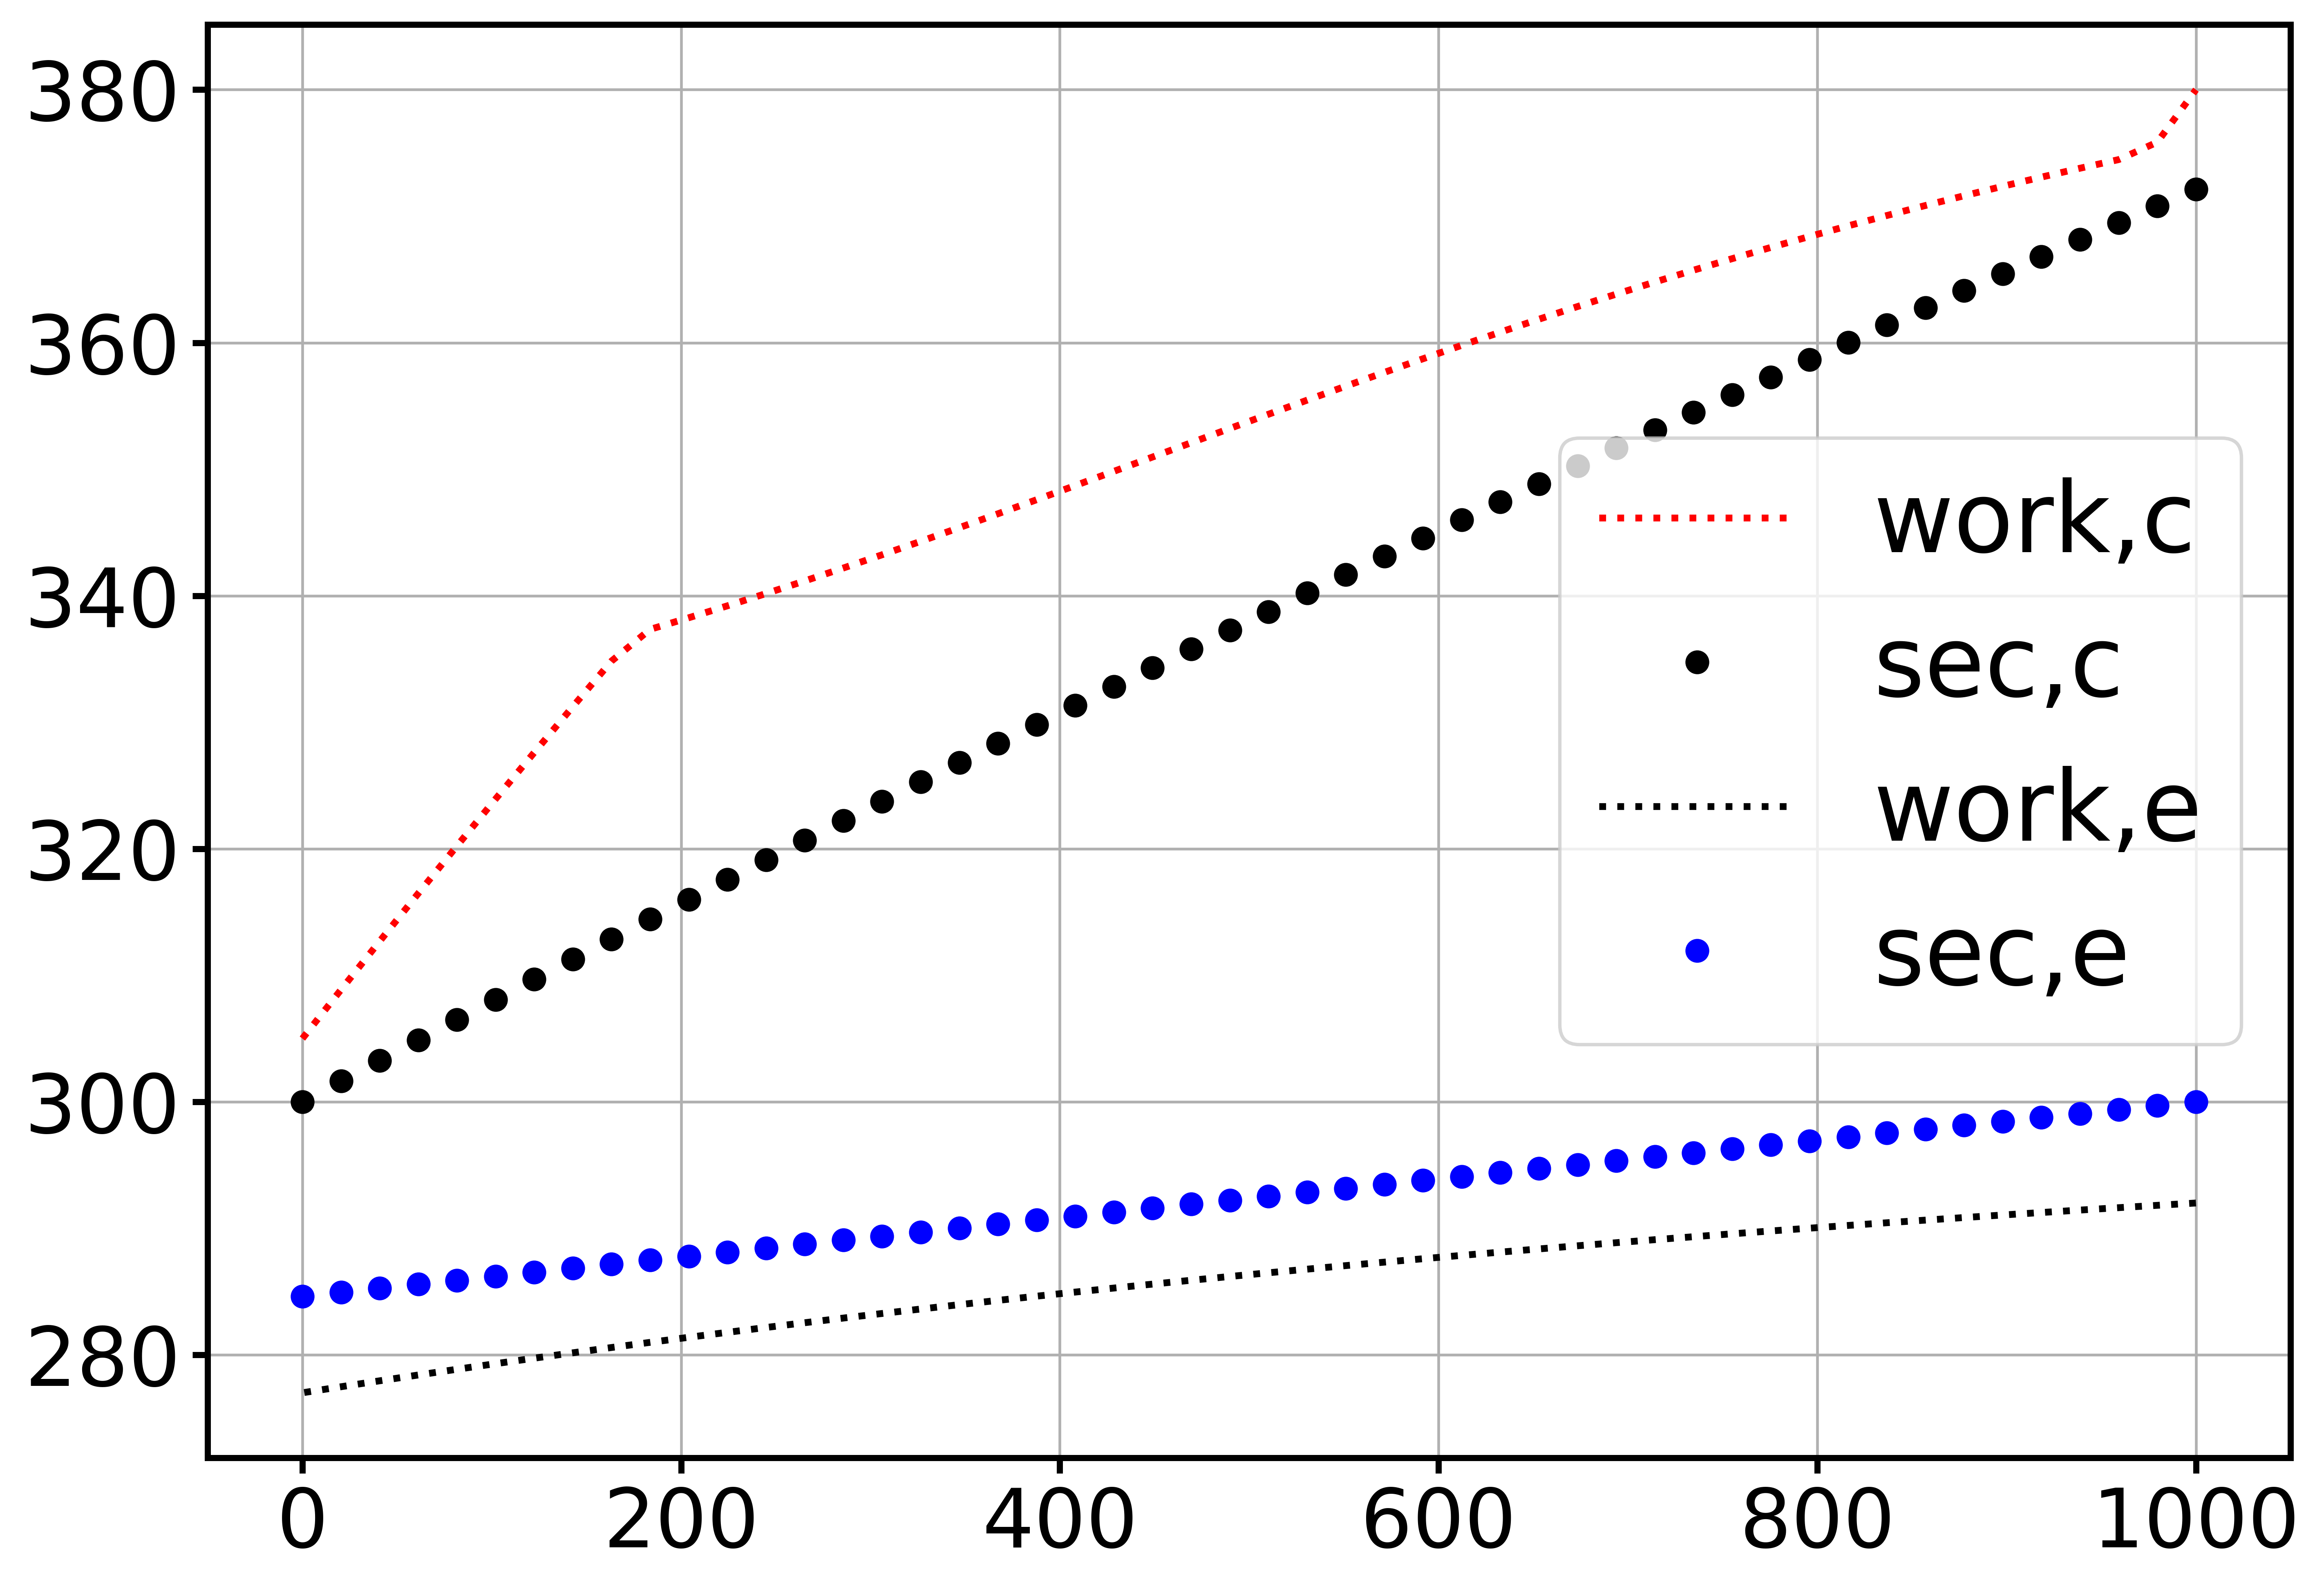

In [23]:
fig_act